# Logistic Regression
In this notebook, we build two implementations of the logistic regression algorithm to classify emails as either spam or not spam.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from matplotlib import rcParams
from sklearn.metrics import accuracy_score, confusion_matrix

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Spam vs. Non-spam
The data consists of examples of spam and non-spam emails, of which there are 4508 training examples and 93 testing examples. The feature vector $x$ is a 57-dimensional vector extracted from the email and $y = 1$ indicates a spam email, otherwise $y = -1$. The data has been preprocessed such that the first 54 dimensions of each observation is binary and the last three dimensions are normalized positive numbers.

In [12]:
data_path = os.path.join('data', 'spam')

X_train = pd.read_csv(os.path.join(data_path, 'X_train.csv'), header = None)
X_test = pd.read_csv(os.path.join(data_path, 'X_test.csv'), header = None)
y_train_orig = pd.read_csv(os.path.join(data_path, 'y_train.csv'), header = None)
y_test_orig = pd.read_csv(os.path.join(data_path, 'y_test.csv'), header = None)

# convert non-spam labels from 0 to -1
y_train = y_train_orig.applymap(lambda x: 1 if x else -1)
y_test = y_test_orig.applymap(lambda x: 1 if x else -1)

# scale the pareto-distributed features
means = X_train.iloc[:, -3:].mean()
stds = X_train.iloc[:, -3:].std()

X_train.iloc[:,-3:] = (X_train.iloc[:,-3:].values - means.values) / stds.values
X_test.iloc[:,-3:] = (X_test.iloc[:,-3:].values - means.values) / stds.values

# Logistic Regression with Steepest Ascent
Let $(x_1, y_1), ..., (x_n, y_n)$ be a set of binary labeled data with $y \in \{-1, +1\}$. **Logistic regression** models each $y_i$ as independently generated, with

$$P(y_i = +1 | x_i, w) = \sigma(x_i^Tw)$$ where $\sigma(x_i;w) = \frac{1}{1 + e^{-x_i^Tw}}$.

The joint likelihood of $y_1, ..., y_n$ is

$$p(y_1, ..., y_n|x_1, ..., x_n, w) = \prod_{i=1}^{n}\sigma(x_i^Tw)^{\mathbb{1}(y_i=+1)}(1-\sigma(x_i^Tw))^{\mathbb{1}(y_i=-1)}$$

The above can be compactly written as:

$$p(y_1, ..., y_n|x_1, ..., x_n, w) = \prod_{i=1}^{n} \sigma(y_ix_i^Tw)$$

Let the log likelihood $\mathcal{L} = \ln \prod_{i=1}^{n} \sigma(y_ix_i^Tw) = \sum_{i=1}^{n}\ln\sigma(y_ix_i^Tw)$. Then we can estimate $w$ using maximum likelihood estimation such that $w_{ML} = \arg\max_w \mathcal{L}$. To maximize $\mathcal{L}$, we can run gradient ascent such that at step $t$, we update:

$$\nabla_w \mathcal{L} = \sum_{i=1}^{n}(1-\sigma(y_ix_i^Tw))y_ix_i$$
$$w^{(t+1)} = w^{(t)}+\eta_t\nabla_w\mathcal{L}$$

where step size $\eta_t = \frac{1}{10^5\sqrt{t+1}}$.

The implementation below is vectorized for faster training times. 

In [5]:
class LogisticRegression:
    
    def __init__(self, include_bias = True, max_iter = int(1e4)):
        self.include_bias = include_bias
        self.max_iter = max_iter
        self.training_loss = list()
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        
        # add a column of ones for w_0
        if self.include_bias:
            X = X.copy()
            X['bias'] = 1
        X = X.values.astype(np.longdouble)
        y = y.values.astype(np.longdouble)
            
        # initialize weight vector with dim = # of features
        w = np.expand_dims(np.zeros(X.shape[1]), axis = 1).astype(np.longdouble)
        
        self.weights_list = list()
        # gradient ascent
        for t in range(self.max_iter):
            # same as X but with each row reflecting sign of y
            X_signed = X * y
            
            # calculate x_i^T times w for all i
            z = X_signed.dot(w)
            
            # element-wise sigmoid transformation of z
            one_minus_sigmoid = 1 - self.sigmoid(z)
            
            # element-to-row-wise multiplication of one_minus_sigmoid with X_signed 
            gradient = one_minus_sigmoid.T.dot(X_signed).T
            
            # update weights
            learning_rate = 1 / (1e5 * np.sqrt(t + 1)).astype(np.longdouble)
            w = w + learning_rate * gradient
            self.weights_list.append(w)
            
            # calculate loss
            z = X_signed.dot(w)
            loss = np.log(self.sigmoid(z)).sum()
            self.training_loss.append(loss)
            
        self.weights_list = np.array(self.weights_list).squeeze()
        self.training_loss = np.array(self.training_loss).squeeze()
        self.weights = w

        return self
    
    def predict_proba(self, X):
        if self.include_bias:
            X = X.copy()
            X['bias'] = 1
        X = X.values
        y_pred = X.dot(self.weights)
        y_pred_logit = 1 / (1 + np.exp(-y_pred))
        
        return y_pred_logit

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.array(probas > 0.5).astype(int) * 2 - 1

We run steepest ascent for 20000 iterations and plot the logistic regression objective training function $\mathcal{L}$ per iteration. 

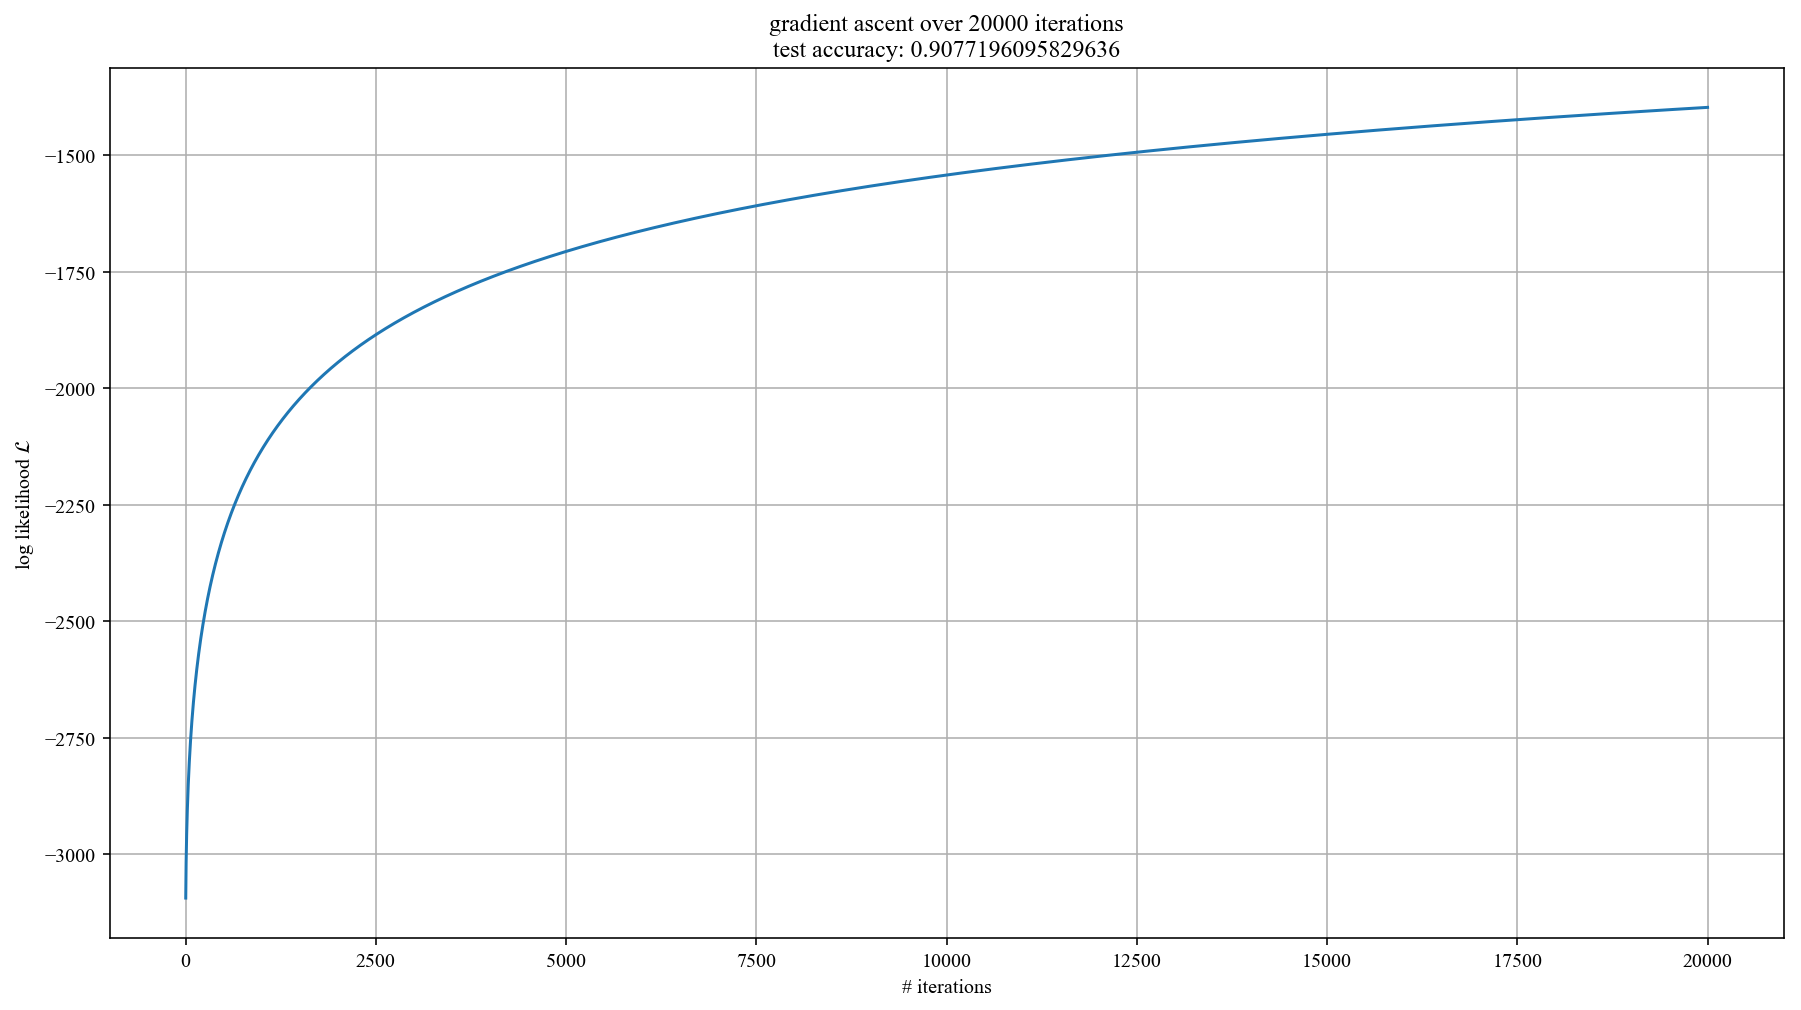

In [15]:
lr = LogisticRegression(max_iter = 20000)
lr.fit(X_train, y_train)

accuracy = accuracy_score(lr.predict(X_train), y_train)

plt.figure(figsize = (15,8))
ax = plt.gca()
ax.plot(np.array(lr.training_loss).squeeze());
ax.set(title = 'gradient ascent over 20000 iterations\ntest accuracy: {}'.format(accuracy),
       xlabel = '# iterations',
       ylabel = 'log likelihood $\mathcal{L}$');
ax.grid('on')

# Logistic Regression with Newton's Method
Finally, we implement a gradient method called **Newton's method** as follows: At iteration $t$, we set:

$$\nabla_w^2\mathcal{L} = -\sum_{i=1}^{n}\sigma(x_i^Tw)(1-\sigma(x_i^Tw))x_ix_i^T$$
$$w^{(t+1)} = w^{(t)} - \eta_t(\nabla_w^2\mathcal{L})^{-1}\nabla_w\mathcal{L}$$

where step size $\eta_t = \frac{1}{\sqrt{t+1}}$.

The implementation below is also vectorized for faster training times.

In [17]:
class LogisticRegressionNewton:
    
    weights = None
    include_bias = None
    training_loss = None
    weights_list = None
    max_iter = None
    
    def __init__(self, include_bias = True, max_iter = int(1e2)):
        self.include_bias = include_bias
        self.max_iter = max_iter
        self.training_loss = list()
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        
        # add a column of ones for w_0
        if self.include_bias:
            X = X.copy()
            X['bias'] = 1
        X = X.values
        y = y.values
            
        # initialize weight vector
        # n_features x 1
        w = np.zeros((X.shape[1], 1))
        
        for t in range(self.max_iter):
            
            # CALCULATE GRADIENT
            # same as X but with each row reflecting sign of y
            # n_records x n_features
            X_signed = X * y
            
            # n_records x 1
            z_signed = X_signed.dot(w)
            one_minus_sigmoid = 1 - self.sigmoid(z_signed)
            
            # element-to-row-wise multiplication of one_minus_sigmoid with X_signed
            # n_features x 1
            gradient = one_minus_sigmoid.T.dot(X_signed).T
            
            # CALCULATE HESSIAN
            # n_records x 1
            z = X.dot(w)
            sigmoid_z = self.sigmoid(z)
            one_minus_sigmoid_z = 1 - sigmoid_z
            j = sigmoid_z * one_minus_sigmoid_z
        
            # n_features x n_features
            j = X.T.dot(X * j)
            j = np.linalg.inv(-j)
            
            # NEWTON UPDATE
            learning_rate = 1 / np.sqrt(t + 1)
            w = w - learning_rate * j.dot(gradient)
            
            # CALCULATE LOSS
            loss = np.log(self.sigmoid(z_signed)).sum()
            self.training_loss.append(loss)
            
        self.weights = w
            
        return self
    
    def predict_proba(self, X):
        if self.include_bias:
            X = X.copy()
            X['bias'] = 1
        X = X.values
        y_pred = X.dot(self.weights)
        y_pred_logit = 1 / (1 + np.exp(-y_pred))
        
        return y_pred_logit.squeeze()

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.array(probas > 0.5).astype(int) * 2 - 1

Below we iterate through Newton's method only 10 times and plot the objective function $\mathcal{L}$ for each iteration. Convergence is incredibly fast!

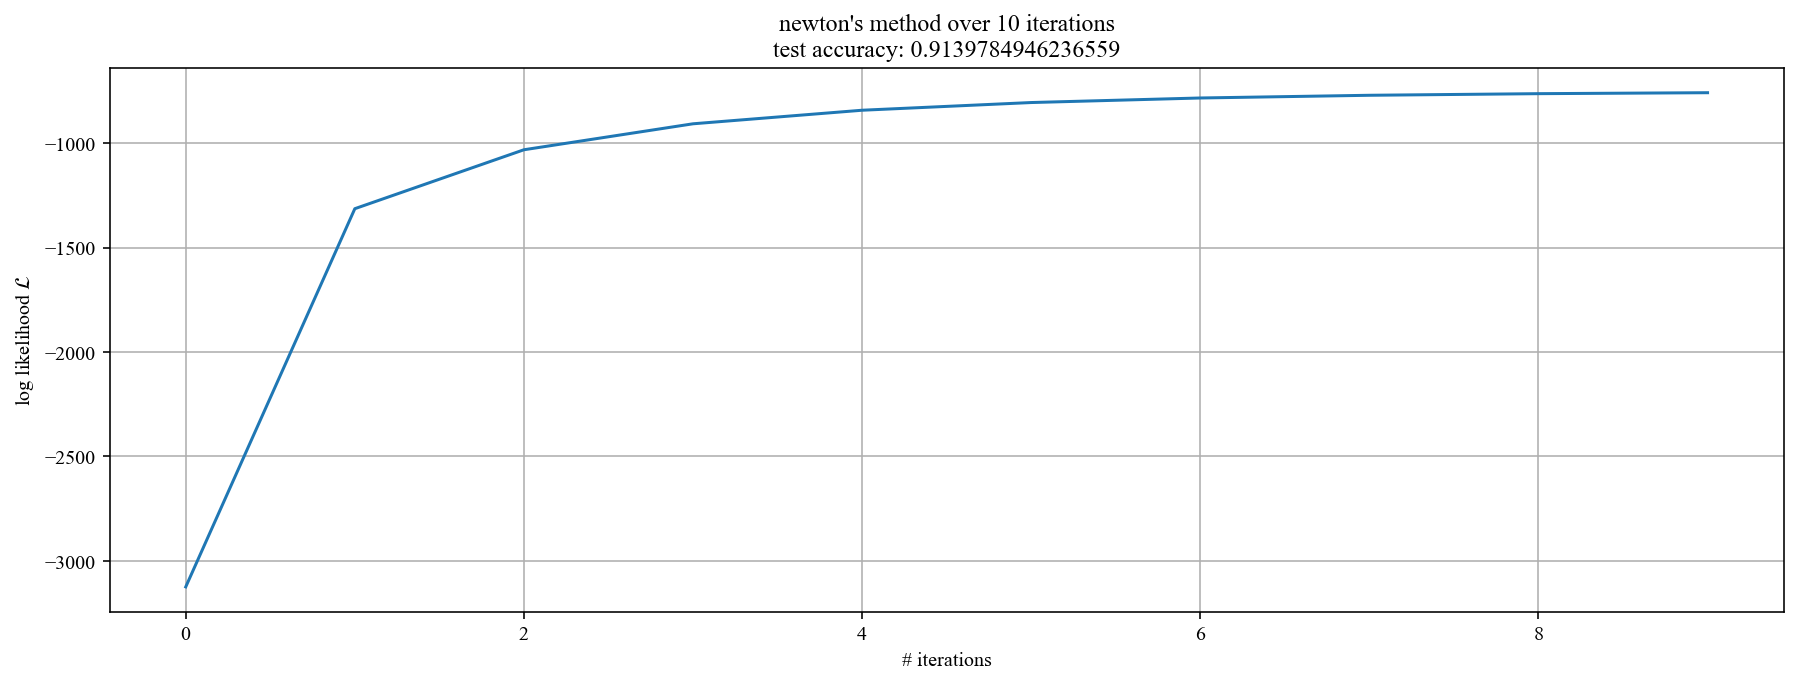

In [24]:
lrn = LogisticRegressionNewton(max_iter = 10)
lrn.fit(X_train, y_train)
accuracy = accuracy_score(y_test, lrn.predict(X_test))

plt.figure(figsize = (15,5))
ax = plt.gca()
ax.plot(lrn.training_loss)
ax.set(title = 'newton\'s method over 10 iterations\ntest accuracy: {}'.format(accuracy),
       xlabel = '# iterations',
       ylabel = 'log likelihood $\mathcal{L}$');
ax.grid('on')